In [1]:
import os
from functools import partial
import pickle
import jax
import jax.numpy as jnp
import optax
import blackjax
from blackjax.sgmcmc.gradients import grad_estimator, logdensity_estimator
import numpy as np
from scipy.stats import t
import pandas as pd
import matplotlib.pyplot as plt
from fastprogress.fastprogress import master_bar, progress_bar
import numpyro
from numpyro.distributions import *
from numpyro.infer.util import initialize_model
from statsmodels.graphics.tsaplots import plot_acf

from progress_bar import scan_tqdm

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=16"

In [2]:
centers = [-0.01, 0, 0.01]
std_devs = [.06, .06, .06]
weights = [0.1, 0.5, 0.4]
observations = pickle.load(open('test/luad34.regions.entropies.observations.pkl', 'rb'))
# num_samples = observations.shape[0]
# degrees_of_freedom = [5, 5, 5]

# samples = []
# for center, std_dev, weight, dof in zip(centers, std_devs, weights, degrees_of_freedom):
#     num_samples_for_this_t = int(num_samples * weight)
#     samples_for_this_t = center + std_dev * t.rvs(dof, size=num_samples_for_this_t)
#     samples.append(samples_for_this_t)

# # samples = []
# # for center, std_dev, weight in zip(centers, std_devs, weights):
# #     num_samples_for_this_gaussian = int(num_samples * weight)
# #     samples_for_this_gaussian = np.random.normal(center, std_dev, num_samples_for_this_gaussian)
# #     samples.append(samples_for_this_gaussian)

# data = np.concatenate(samples)

# plt.figure(figsize=(10, 6))
# plt.hist(data, bins=10000, density=True, alpha=0.6, color='g')

# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# for center, std_dev, weight, dof in zip(centers, std_devs, weights, degrees_of_freedom):
#     p = weight * t.pdf((x - center) / std_dev, dof) / std_dev
#     plt.plot(x, p, 'k', linewidth=2)

# # plt.title('Fit results: Centers = %s, Std Deviations = %s, Weights = %s, Degrees of Freedom = %s' % (centers, std_devs, weights, degrees_of_freedom))
# plt.title('Simulated data')
# plt.xlim([-0.2, 0.2])
# plt.ylim([0, 8])
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.hist(observations, bins=10000, density=True, alpha=0.6, color='g')
# plt.title('Observed data')
# plt.xlim([-0.2, 0.2])
# plt.ylim([0, 8])
# plt.show()


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


  0%|          | 0/10000 [00:00<?, ?it/s]

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

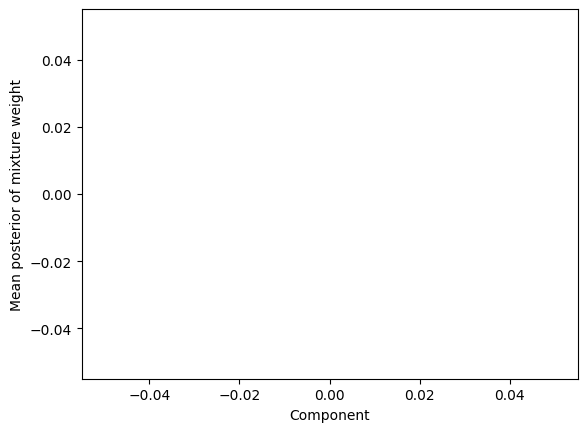

NameError: name 'mu_posterior_mean' is not defined

<Figure size 1000x600 with 0 Axes>

In [5]:
def inverse_softplus(y):
    return jnp.log(np.exp(y) - 1)

def inverse_sigmoid(y):
    return jnp.log(y / (1 - y))

def mu(n, s, phi, c, cs):
    return jnp.log2((2 * n + (1 - n) * (s * c + (1 - s) * cs)) / \
                        (2 * n + (1 - n) * phi))

def stick_breaking(beta, epsilon=1e-10):
    portion_remaining = jnp.concatenate([jnp.array([1.0]), jnp.cumprod(1.0 - beta[:-1] + epsilon)])
    probabilities = beta * portion_remaining
    return probabilities / jnp.sum(probabilities)

def logprior_fn(params):
    alpha_param, beta_param, n_param, nu_param, s_param, scale_param = jax.tree_util.tree_flatten(params)[0]
    alpha = jax.nn.softplus(alpha_param)
    beta = jax.nn.sigmoid(beta_param)

    scale = jax.nn.softplus(scale_param)
    nu = jax.nn.softplus(nu_param)

    n = jax.nn.sigmoid(n_param)
    s = jax.nn.sigmoid(s_param)
    
    log_prior =  \
            Gamma(1, 1).log_prob(alpha) + \
            jnp.sum(Beta(2, alpha).log_prob(beta), axis=-1) + \
            jnp.sum(HalfNormal(1).log_prob(scale), axis=-1) + \
            jnp.sum(Gamma(1, .1).log_prob(nu), axis=-1) + \
            Beta(2, 20).log_prob(s) + \
            Beta(20, 2).log_prob(n)
            
    return log_prior

def loglikelihood_fn(params, data):
    _, beta_param, n_param, nu_param, s_param, scale_param = jax.tree_util.tree_flatten(params)[0]
    beta = jax.nn.sigmoid(beta_param)
    weights = stick_breaking(beta)

    scale = jax.nn.softplus(scale_param)
    nu = jax.nn.softplus(nu_param)

    n = jax.nn.sigmoid(n_param)
    s = jax.nn.sigmoid(s_param)
    
    equal_states = jnp.all(states[:, 0] == states[:, 1])
    s_ = jnp.where(equal_states, 0, s)
    phi = (1-s_) * jnp.sum(weights * states[:, 0]) + s_ * jnp.sum(weights * states[:, 1])
    mu = jnp.log2((2 * n + (1 - n) * ((1 - s_) * states[:, 0] + s_ * states[:, 1])) / \
                        (2 * n + (1 - n) * phi))
    
    component_dists = StudentT(nu, mu, scale)
    likelihood_dist = MixtureSameFamily(Categorical(weights), component_dists)
    log_likelihood = jnp.sum(likelihood_dist.log_prob(data))

    penalty = jnp.where((phi < 2) | (phi > 4), 1e-3, 0)

    return log_likelihood - penalty

key = jax.random.PRNGKey(np.random.randint(0, 1000))

states = []
for i in range(10):
    for j in [i-1, i, i + 1]:
        if j < 0: continue
        states.append([i, j])
states = jnp.array(states)
max_cluster_num = len(states)
alpha = inverse_softplus(0.5)
beta = inverse_sigmoid(jnp.ones(max_cluster_num) * 0.005)
scale = inverse_softplus(jnp.ones(max_cluster_num) * 0.005)
nu = inverse_softplus(jnp.ones(max_cluster_num) * 2)
n = inverse_sigmoid(0.5)
s = inverse_sigmoid(0.5)

init_params = {'alpha': alpha, 'beta': beta, 'nu': nu, 'scale': scale, 'n': n, 's': s}

data_size = len(observations)
batch_size = data_size // 10
key = jax.random.PRNGKey(np.random.randint(0, 1000))
init_step_size = 1e-8
zeta = 1
sz = 5
num_samples = 10_000
sample_size = 1_000
# schedule_fn = optax.linear_schedule(init_step_size, 1e-6, num_warmup+num_samples)
# schedule_fn = lambda _: init_step_size
grad_fn = grad_estimator(logprior_fn, loglikelihood_fn, data_size)
logdensity_fn = logdensity_estimator(logprior_fn, loglikelihood_fn, sample_size)

# kernel = blackjax.sgld(grad_fn)
kernel = blackjax.csgld(logdensity_fn, grad_fn, zeta=zeta)
# kernel = blackjax.sghmc(grad_fn, 20)
# kernel = blackjax.sgnht(key, grad_fn)

state = kernel.init(init_params)

def inference_loop(rng_key, mcmc_kernel, initial_state, num_samples, data, batch_size, step_size):
    
    @jax.jit
    @scan_tqdm(num_samples, print_rate=1)
    def one_step(state, x):
        rng_key, batch_key, sample_key = jax.random.split(jax.random.PRNGKey(np.random.randint(0, 1000000)), 3)
        mini_batch = jax.random.permutation(batch_key, observations, independent=True)[:batch_size]
        state = mcmc_kernel(rng_key, state, mini_batch, step_size, 1e-4)
        return state, state

    _, states = jax.lax.scan(one_step, initial_state, jnp.arange(num_samples))

    return states

samples = inference_loop(key, kernel.step, state, num_samples, observations, batch_size, init_step_size)
samples = samples.position

alpha_posterior = jax.nn.softplus(samples['alpha'][-sample_size:])
beta_posterior = jax.nn.sigmoid(samples['beta'][-sample_size:])
scale_posterior = jax.nn.softplus(samples['scale'][-sample_size:])
nu_posterior = jax.nn.softplus(samples['nu'][-sample_size:])
n_posterior = jax.nn.sigmoid(samples['n'][-sample_size:])
s_posterior = jax.nn.sigmoid(samples['s'][-sample_size:])

alpha_posterior_mean = jnp.mean(alpha_posterior)
beta_posterior_mean = jnp.mean(beta_posterior, axis=0)
weights_posterior_mean = stick_breaking(beta_posterior_mean)
scale_posterior_mean = jnp.mean(scale_posterior, axis=0)
nu_posterior_mean = jnp.mean(nu_posterior, axis=0)
n_posterior_mean = jnp.mean(n_posterior)
s_posterior_mean = jnp.mean(s_posterior)
weights_posterior_mean = stick_breaking(beta_posterior_mean)

phi = (1-s_posterior_mean) * jnp.sum(weights_posterior_mean * states[:, 0]) + s_posterior_mean * jnp.sum(weights_posterior_mean * states[:, 1])
mu = jnp.log2((2 * n_posterior_mean + (1 - n_posterior_mean) * ((1 - s_posterior_mean) * states[:, 0] + s_posterior_mean * states[:, 1])) / \
                        (2 * n_posterior_mean + (1 - n_posterior_mean) * phi))
states = pd.DataFrame({
    'beta': beta_posterior_mean,
    'scale': scale_posterior_mean,
    'nu': nu_posterior_mean,
    'mu': mu,
    'weights': weights_posterior_mean
})

plt.ylabel('Mean posterior of mixture weight')
plt.xlabel('Component')
bars = plt.bar(range(0, max_cluster_num), states['weights'])
for bar, state in zip(bars, range(0, max_cluster_num)):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.005, state, color='black', fontsize=10, rotation=90)
plt.show()

plt.figure(figsize=(10, 6))
x = np.linspace(-.25, .25, 1000)
for df, loc, scale, weight in zip(nu_posterior_mean, mu, scale_posterior_mean, weights_posterior_mean):
    y = t.pdf(x, df, loc, scale)
    plt.plot(x, y * weight)
plt.hist(observations, bins=100, density=True, label='Data', alpha=0.3)
plt.legend()
plt.xlim(-.25, .25)
plt.ylim(0, 10)
plt.show()

states.sort_values('weights', ascending=False)

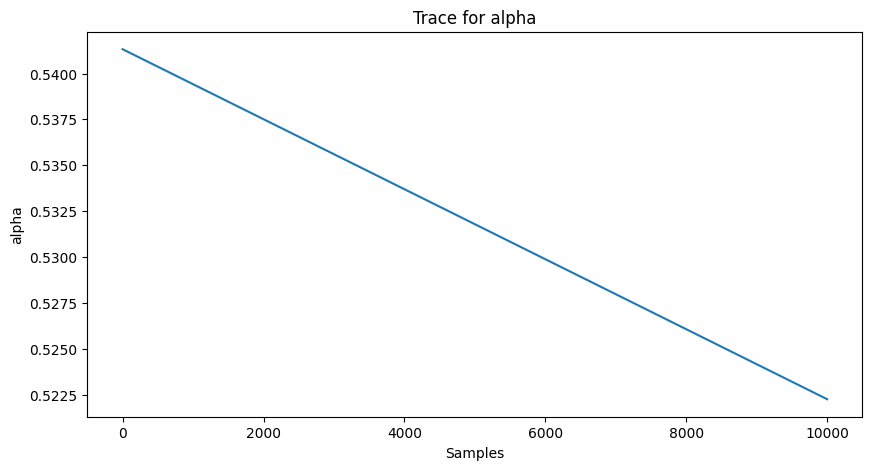

<Figure size 1000x500 with 0 Axes>

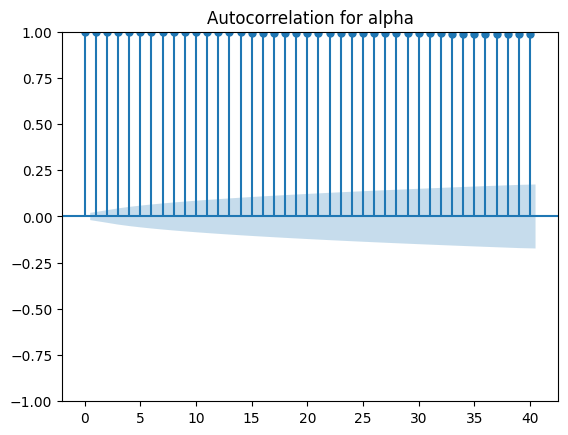

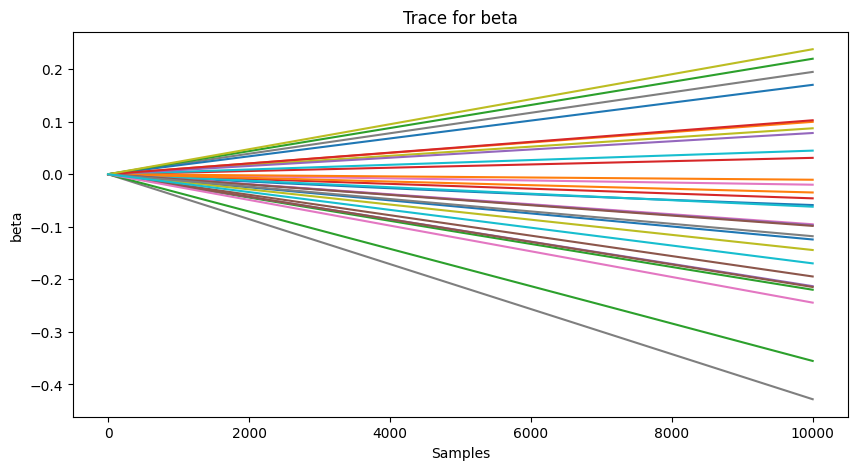

ValueError: x is required to have ndim 1 but has ndim 2

<Figure size 1000x500 with 0 Axes>

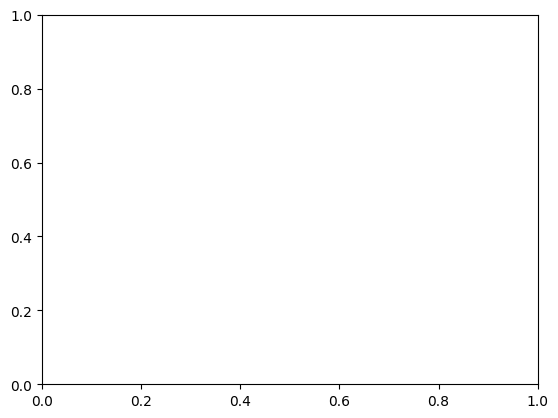

In [59]:
def plot_trace(samples, param_name):
    plt.figure(figsize=(10, 5))
    plt.plot(samples[param_name])
    plt.title(f"Trace for {param_name}")
    plt.xlabel("Samples")
    plt.ylabel(f"{param_name}")
    plt.show()

def plot_autocorr(samples, param_name):
    plt.figure(figsize=(10, 5))
    plot_acf(np.array(samples[param_name]), lags=40)  # You can adjust the number of lags if needed
    plt.title(f"Autocorrelation for {param_name}")
    plt.show()

for param in ['alpha', 'beta', 'mu', 'nu', 'scale']:
    plot_trace(samples, param)
    plot_autocorr(samples, param)

In [33]:
jnp.mean(samples['mu'][-sample_size:], axis=0)

Array([ -0.94088405,   3.5889616 ,  -4.139499  ,  -1.0478299 ,
        -1.3530786 ,   0.54726857,  -3.9961536 ,  -2.8758752 ,
        -0.51308495,  -2.3117135 ,  -5.259906  , -12.601093  ,
         0.5223788 ,   4.910264  ,  -0.5961659 ,   8.343055  ,
         0.7550259 ,  -1.1986425 ,   3.6324139 ,   4.238633  ,
        11.882466  ,   7.620027  ,  -5.151726  ,  -1.0479822 ,
        -0.09215505,  -3.7534676 ,  -3.9903753 ,  -6.3296366 ,
         5.1839905 ,   4.4349103 ], dtype=float32)

In [162]:
def inverse_sigmoid(y):
    return jnp.log(y / (1 - y))

def inverse_softplus(y):
    return jnp.log(np.exp(y) - 1)

def stick_breaking(beta):
    portion_remaining = jnp.concatenate([jnp.array([1]), jnp.cumprod(1 - beta[:-1])])
    return beta * portion_remaining

def dirichlet_prior(states, target_state=jnp.array([2,2]), alpha=1.0):
    distances = jnp.linalg.norm(states - target_state, axis=1)
    return jnp.exp(-distances**2 / (2*alpha**2))

def gamma_distribution(x, alpha, beta):
    return jnp.exp(jnp.log(beta)*alpha + (alpha-1)*jnp.log(x) - beta*x - jax.scipy.special.gammaln(alpha))

def gamma_prior(points, target_point=jnp.array([2, 2]), alpha=1.0, beta=1.0, epsilon=1e-10):
    distances = jnp.linalg.norm(points - target_point, axis=1) + epsilon
    gamma_values = gamma_distribution(distances, alpha, beta)
    return gamma_values

def logprior_fn(params):
    alpha_param, n_param, nu_param, phi_param, s_param, scale_param, weights_param = jax.tree_util.tree_flatten(params)[0]
    alpha = jax.nn.softplus(alpha_param)
    weights = jax.nn.softmax(weights_param, axis=-1)
    n = jax.nn.sigmoid(n_param)
    s = jax.nn.sigmoid(s_param)
    phi = jax.nn.softplus(phi_param)
    scale = jax.nn.softplus(scale_param)
    nu = jax.nn.softplus(nu_param)
    log_prior =  \
            InverseGamma(1, 1).log_prob(alpha) + \
            Dirichlet(jnp.ones(max_cluster_num) / max_cluster_num * alpha).log_prob(weights) + \
            Beta(20, 2).log_prob(n) + \
            Beta(2, 20).log_prob(s) + \
            InverseGamma(3, 1).log_prob(phi) + \
            jnp.sum(InverseGamma(1, 1).log_prob(scale), axis=-1) + \
            jnp.sum(InverseGamma(1, 1).log_prob(nu), axis=-1)
    return log_prior / data_size

def loglikelihood_fn(params, data):
    _, n_param, nu_param, phi_param, s_param, scale_param, weights_param = jax.tree_util.tree_flatten(params)[0]
    weights = jax.nn.softmax(weights_param, axis=-1)
    n = jax.nn.sigmoid(n_param)
    s = jax.nn.sigmoid(s_param)
    phi = jax.nn.softplus(phi_param)
    scale = jax.nn.softplus(scale_param)
    nu = jax.nn.softplus(nu_param)
    
    mu = jnp.log2((2 * n + (1 - n) * (s * states[:, 0] + (1 - s) * states[:, 1])) / \
                        (2 * n + (1 - n) * phi))
    

    likelihood_dist = MixtureSameFamily(Categorical(weights), StudentT(nu, mu, scale))

    target_weights = gamma_prior(states, alpha=1, beta=1.1)
    lambda_reg = 0.01
    log_likelihood = jnp.sum(likelihood_dist.log_prob(data))
    regularization_term = -lambda_reg * jnp.sum((weights - target_weights)**2)
    return (log_likelihood + regularization_term) / batch_size

def full_logdensity_fn(params, data=observations):
    frac = data_size // 100
    data = jax.random.permutation(key, data, independent=True)[:frac]
    return logprior_fn(params) + loglikelihood_fn(params, data)

clonal = 6
states_set = \
    [[0, 0],
    [1, 1],
    [1, 2],
    [2, 1],
    [2, 2],
    [2, 3],
    [3, 3],
    [4, 4],
    [5, 5]]
states_df = pd.DataFrame(states_set, columns=['clonal', 'subclonal'])
states = jnp.array(states_df.values, dtype=jnp.float32)
max_cluster_num = len(states)

data_size = observations.shape[0]
batch_size = data_size // 10

alpha = inverse_softplus(1.0)
weights = gamma_prior(states, alpha=0.99, beta=1.1)
n = inverse_sigmoid(0.9)
s = inverse_sigmoid(0.1)
phi = inverse_softplus(2.5)
scale = inverse_softplus(jnp.ones(max_cluster_num) / max_cluster_num)
nu = inverse_softplus(jnp.ones(max_cluster_num) * 2)
init_params = {"alpha": alpha, "weights": weights, "scale": scale, "nu": nu, "phi": phi, "s": s, "n": n}

key = jax.random.PRNGKey(42)
init_step_size = 1e-5
zeta = 0
sz = 5
num_samples = 1
sample_size = 1_000
# schedule_fn = optax.linear_schedule(init_step_size, 1e-6, num_warmup+num_samples)
# schedule_fn = lambda _: init_step_size
grad_fn = grad_estimator(logprior_fn, loglikelihood_fn, data_size)
logdensity_fn = logdensity_estimator(logprior_fn, loglikelihood_fn, sample_size)

# kernel = blackjax.sgld(grad_fn)
# kernel = blackjax.csgld(logdensity_fn, grad_fn, zeta=zeta)
# kernel = blackjax.sghmc(grad_fn, 10)
kernel = blackjax.sgnht(key, grad_fn)

state = kernel.init(init_params, key)

def inference_loop(rng_key, mcmc_kernel, initial_state, num_samples, data, batch_size, step_size):
    
    @jax.jit
    @scan_tqdm(num_samples, print_rate=1)
    def one_step(state, x):
        rng_key, batch_key, sample_key = jax.random.split(jax.random.PRNGKey(np.random.randint(0, 1000000)), 3)
        mini_batch = jax.random.permutation(batch_key, observations, independent=True)[:batch_size]
        state = mcmc_kernel(rng_key, state, mini_batch, step_size)
        return state, state

    _, states = jax.lax.scan(one_step, initial_state, jnp.arange(num_samples))

    return states

samples = inference_loop(key, kernel.step, state, num_samples, observations, batch_size, init_step_size)
# samples = samples.position

alpha_posterior = jax.nn.softplus(samples['alpha'][-sample_size:])
weights_posterior = jax.nn.softmax(samples['weights'][-sample_size:], axis=1)
n_posterior = jax.nn.sigmoid(samples['n'][-sample_size:])
s_posterior = jax.nn.sigmoid(samples['s'][-sample_size:])
phi_posterior = jax.nn.softplus(samples['phi'][-sample_size:])
scale_posterior = jax.nn.softplus(samples['scale'][-sample_size:])
nu_posterior = jax.nn.softplus(samples['nu'][-sample_size:])

alpha_posterior_mean = jnp.mean(alpha_posterior)
weights_posterior_mean = jnp.mean(weights_posterior, axis=0)
n_posterior_mean = jnp.mean(n_posterior)
s_posterior_mean = jnp.mean(s_posterior)
phi_posterior_mean = jnp.mean(phi_posterior)
scale_posterior_mean = jnp.mean(scale_posterior, axis=0)
nu_posterior_mean = jnp.mean(nu_posterior, axis=0)

print(f'n: {n_posterior_mean}')
print(f's: {s_posterior_mean}')
print(f'phi: {phi_posterior_mean}')
print(f'alpha: {alpha_posterior_mean}')

plt.ylabel('Mean posterior of mixture weight')
plt.xlabel('Component')
bars = plt.bar(range(0, max_cluster_num), weights_posterior_mean)
for bar, state in zip(bars, states):
    state = f'{int(state[0])}, {int(state[1])}'
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.005, state, color='black', fontsize=10, rotation=90)
plt.show()


plt.ylabel('Sample value of alpha')
plt.xlabel('Iteration')
plt.plot(jax.nn.sigmoid(samples['alpha']))
plt.show()

TypeError: Value <function logdensity_estimator.<locals>.logdensity_estimator_fn at 0x7f927f286a20> with type <class 'function'> is not a valid JAX type

In [149]:
nu_posterior_mean

Array([1.7491122, 1.742465 , 1.1682185, 2.206932 , 2.4870515, 1.7983557,
       1.1412479, 3.108886 , 1.4196712], dtype=float32)

In [ ]:

def inference_loop(rng_key, mcmc_kernel, initial_state, num_samples, data, batch_size, step_size):
    
    @jax.jit
    def one_step(state, k):
        mini_batch = jax.random.permutation(batch_key, observations, independent=True)[:batch_size]
        state = mcmc_kernel(k, state, mini_batch, step_size)
        return state, state

    rng_key, batch_key, sample_key = jax.random.split(rng_key, 3)
    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states
key = jax.random.PRNGKey(42)
samples = inference_loop(key, kernel.step, state, num_samples, observations, batch_size, init_step_size)

alpha_posterior = jax.nn.softplus(samples['alpha'][-sample_size:])
weights_posterior = jax.nn.softmax(samples['weights'][-sample_size:], axis=1)
n_posterior = jax.nn.sigmoid(samples['n'][-sample_size:])
s_posterior = jax.nn.sigmoid(samples['s'][-sample_size:])
phi_posterior = jax.nn.softplus(samples['phi'][-sample_size:])
scale_posterior = jax.nn.softplus(samples['scale'][-sample_size:])
nu_posterior = jax.nn.softplus(samples['nu'][-sample_size:])

alpha_posterior_mean = jnp.mean(alpha_posterior)
weights_posterior_mean = jnp.mean(weights_posterior, axis=0)
n_posterior_mean = jnp.mean(n_posterior)
s_posterior_mean = jnp.mean(s_posterior)
phi_posterior_mean = jnp.mean(phi_posterior)
scale_posterior_mean = jnp.mean(scale_posterior, axis=0)
nu_posterior_mean = jnp.mean(nu_posterior, axis=0)

plt.ylabel('Mean posterior of mixture weight')
plt.xlabel('Component')
bars = plt.bar(range(0, max_cluster_num), weights_posterior_mean)
for bar, state in zip(bars, states):
    state = f'{int(state[0])}, {int(state[1])}'
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.005, state, color='black', fontsize=10, rotation=90)
plt.show()


plt.ylabel('Sample value of alpha')
plt.xlabel('Iteration')
plt.plot(alpha_posterior)
plt.show()

In [13]:

beta_posterior, weights_posterior, s_posterior, n_posterior, phi_posterior, scale_posterior, nu_posterior = [], [], [], [], [], [], []
rng_key = jax.random.PRNGKey(np.random.randint(0, 1000))
schedule_fn = lambda _: init_step_size
pb = progress_bar(range(num_samples))
for step in pb:
    rng_key, batch_key, sample_key = jax.random.split(rng_key, 3)
    batch = jax.random.permutation(batch_key, observations, independent=True)[:batch_size]
    # stepsize_SA = min(1e-2, (step + 100) ** (-0.8)) * sz
    state = jax.jit(kernel.step)(sample_key, state, batch, schedule_fn(step))
    # state = jax.jit(csgld.step)(sample_key, state, batch, schedule_fn(step), 1e-4)
    # state = jax.jit(sghmc.step)(sample_key, state, batch, schedule_fn(step))
    # state = jax.jit(sgnht.step)(rng_key, sample_key, state, batch, 1e-3)
    if step % 100 == 0:
        pb.comment = f" n: {jax.nn.sigmoid(state['n']):.4f} | " + \
                    f" s: {jax.nn.sigmoid(state['s']):.4f} | " + \
                    f" phi: {jax.nn.softplus(state['phi']):.4f} | " + \
                        f"{'warmup' if step < num_warmup else 'sampling'}"
        # pb.comment = f" alpha: {jax.nn.softplus(state.position['alpha']):.4f} | " + \
        #             f" n: {jax.nn.sigmoid(state.position['n']):.4f} | " + \
        #             f" s: {jax.nn.sigmoid(state.position['s']):.4f} | " + \
        #             f" phi: {(jax.nn.softplus(state.position['phi'])):.4f} | " + \
        #                 f"{'warmup' if step < num_warmup else 'sampling'}"

    if step > num_warmup:
        # alpha_posterior.append(state.position['alpha'])
        # weights_posterior.append(state.position['weights'])
        # n_posterior.append(state.position['n'])
        # s_posterior.append(state.position['s'])
        # phi_posterior.append(state.position['phi'])
        # scale_posterior.append(state.position['scale'])
        # nu_posterior.append(state.position['nu'])
        alpha_posterior.append(state['alpha'])
        weights_posterior.append(state['weights'])
        n_posterior.append(state['n'])
        s_posterior.append(state['s'])
        phi_posterior.append(state['phi'])
        scale_posterior.append(state['scale'])
        nu_posterior.append(state['nu'])

alpha_posterior = jax.nn.softplus(jnp.array(alpha_posterior))
weights_posterior = jax.nn.softmax(jnp.array(weights_posterior), axis=-1)
n_posterior = jax.nn.sigmoid(jnp.array(n_posterior))
s_posterior = jax.nn.sigmoid(jnp.array(s_posterior))
phi_posterior = jax.nn.softplus(jnp.array(phi_posterior))
scale_posterior = jax.nn.softplus(jnp.array(scale_posterior))
nu_posterior = jax.nn.softplus(jnp.array(nu_posterior))

alpha_mean = jnp.mean(alpha_posterior[-sample_size:], axis=0)
weights_mean = jnp.mean(weights_posterior[-sample_size:], axis=0)
n_mean = jnp.mean(n_posterior[-sample_size:], axis=0)
s_mean = jnp.mean(s_posterior[-sample_size:], axis=0)
phi_mean = jnp.mean(phi_posterior[-sample_size:], axis=0)
scale_mean = jnp.mean(scale_posterior[-sample_size:], axis=0)
nu_mean = jnp.mean(nu_posterior[-sample_size:], axis=0)

plt.ylabel('Mean posterior of mixture weight')
plt.xlabel('Component')
plt.bar(range(0, max_cluster_num), weights_mean)
plt.show()

plt.ylabel('Sample value of alpha')
plt.xlabel('Iteration')
plt.plot(alpha_posterior)
plt.show()

TypeError: Argument '5, 6' of type <class 'str'> is not a valid JAX type

In [47]:
n_mean, s_mean, phi_mean

(Array(0.19617659, dtype=float32),
 Array(0.34438547, dtype=float32),
 Array(3.3478127, dtype=float32))

In [85]:
states_df

,clonal,subclonal
0,0,0
1,0,1
2,1,0
3,1,1
4,1,2
5,2,1
6,2,2
7,2,3
8,3,2
9,3,3


/home/hadas/miniconda3/envs/jax/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (55) in plot_autocorr, generating only 40 plots
  warnings.warn(


<xarray.Dataset>
Dimensions:        (alpha_dim_0: 1, weights_dim_0: 17, n_dim_0: 1, s_dim_0: 1,
                    phi_dim_0: 1, scale_dim_0: 17, nu_dim_0: 17)
Coordinates:
  * alpha_dim_0    (alpha_dim_0) int64 0
  * weights_dim_0  (weights_dim_0) int64 0 1 2 3 4 5 6 ... 10 11 12 13 14 15 16
  * n_dim_0        (n_dim_0) int64 0
  * s_dim_0        (s_dim_0) int64 0
  * phi_dim_0      (phi_dim_0) int64 0
  * scale_dim_0    (scale_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * nu_dim_0       (nu_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
Data variables:
    alpha          (alpha_dim_0) float64 nan
    weights        (weights_dim_0) float64 nan nan nan nan ... nan nan nan nan
    n              (n_dim_0) float64 nan
    s              (s_dim_0) float64 nan
    phi            (phi_dim_0) float64 nan
    scale          (scale_dim_0) float64 nan nan nan nan nan ... nan nan nan nan
    nu             (nu_dim_0) float64 nan nan nan nan nan ... nan nan nan nan
<xarray.Dat

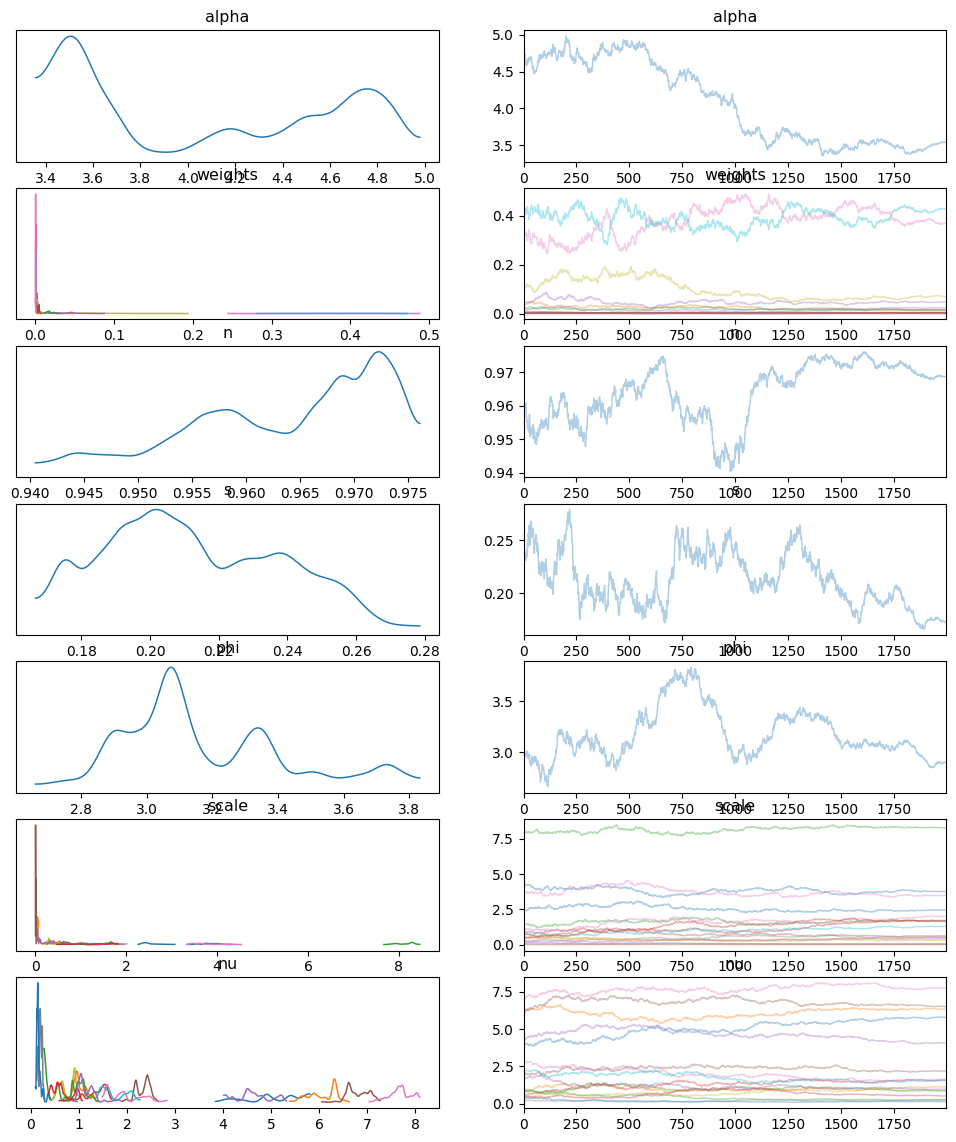

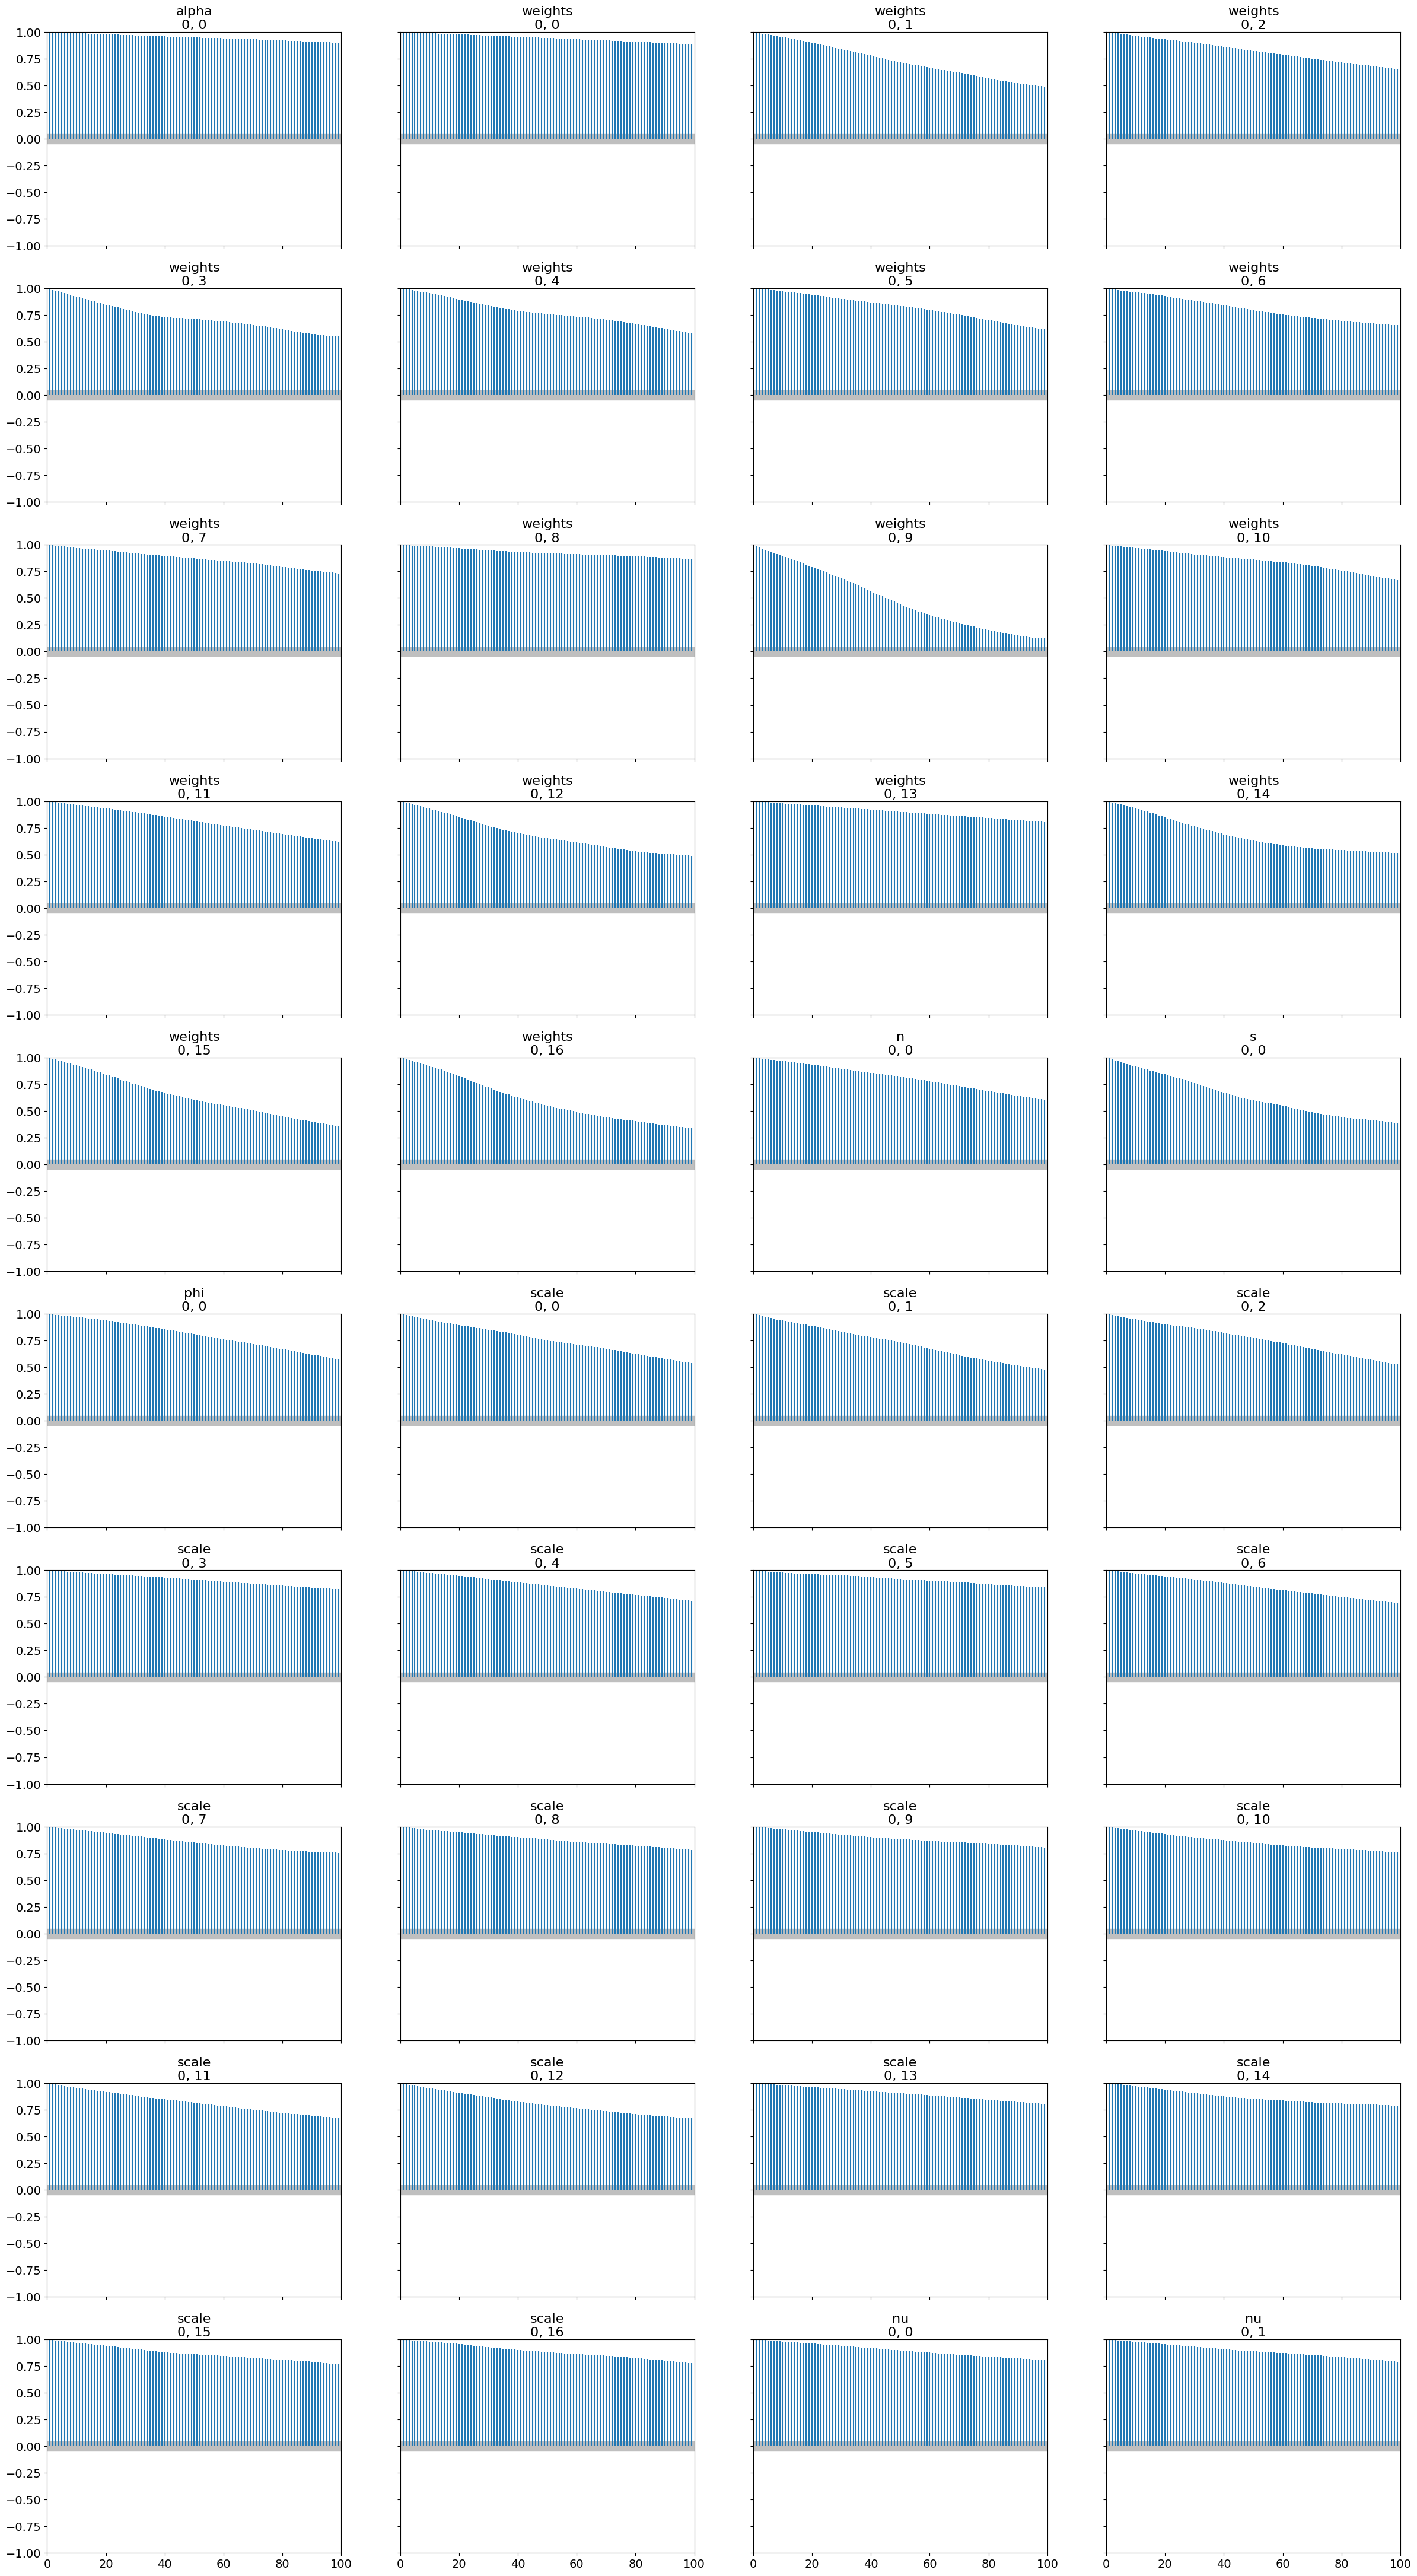

In [86]:
import arviz as az

idata = az.from_dict(
    posterior={
        "alpha": alpha_posterior.reshape(1, -1, 1),
        "weights": weights_posterior.reshape(1, -1, max_cluster_num),
        "n": n_posterior.reshape(1, -1, 1),
        "s": s_posterior.reshape(1, -1, 1),
        "phi": phi_posterior.reshape(1, -1, 1),
        "scale": scale_posterior.reshape(1, -1, max_cluster_num),
        "nu": nu_posterior.reshape(1, -1, max_cluster_num),
    }
)

# plot trace
az.plot_trace(idata)

# plot autocorrelation
az.plot_autocorr(idata)

# compute and print Gelman-Rubin diagnostic
r_hat = az.rhat(idata)
print(r_hat)

# compute and print effective sample size
ess = az.ess(idata)
print(ess)


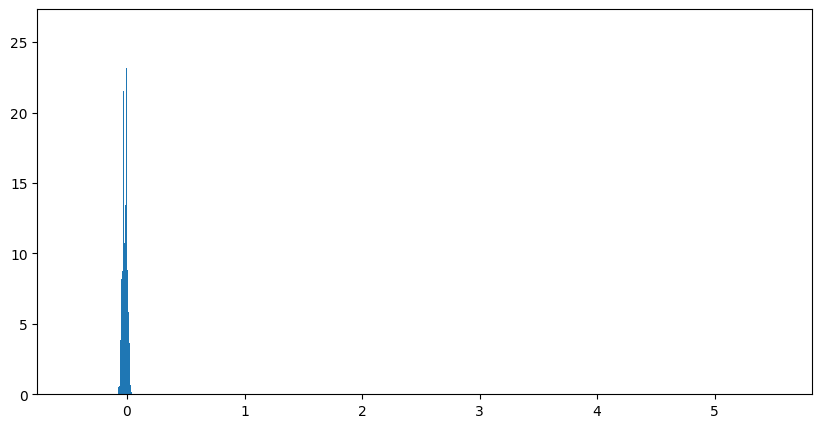

In [ ]:
def dirichlet_prior(states, target_state=jnp.array([2,2]), sigma=1.0):
    distances = jnp.linalg.norm(states - target_state, axis=1)
    return jnp.exp(-distances**2 / (2*sigma**2))

def generate_synthetic_data(s, n, phi, scale, nu, states, num_samples):
    weights = dirichlet_prior(states)
    mu = jnp.log((2 * n + (1 - n) * ((1 - s) * states[:, 0] + s * states[:, 1])) / (2 * n + (1 - n) * phi))
    component_indices = Categorical(probs=weights).sample(jax.random.PRNGKey(0), (num_samples,))
    synthetic_data = np.zeros(num_samples)
    for i in range(num_samples):
        component_index = component_indices[i]
        synthetic_data[i] = StudentT(nu[component_index], mu[component_index], scale[component_index]).sample(jax.random.PRNGKey(i))
    
    return synthetic_data

s = 0.4
n = 0.95
phi = 2.7
clonal = 6
states_set = {(c, c-1) for c in range(1, clonal)} | \
        {(c, c) for c in range(clonal)} | \
        {(c, c+1) for c in range(clonal)} | \
        {(c, 2) for c in range(clonal)}
states_df = pd.DataFrame(states_set, columns=['clonal', 'subclonal'])
states = jnp.array(states_df.values, dtype=jnp.float32)
n_states = len(states)
scale = jnp.ones(n_states) * 0.002
nu = jnp.ones(n_states) * 2.1
num_samples = 50000
# observations = generate_synthetic_data(s, n, phi, scale, nu, states, num_samples)

regions = pickle.load(open('test/luad34.regions.entropies.pkl', 'rb'))
observations = jnp.array(regions[regions.chrom != 19].loc[:, 'log2_corrected'].values)
num_samples = observations.shape[0]
observations = generate_synthetic_data(s, n, phi, scale, nu, states, num_samples)

plt.figure(figsize=(10, 5))
plt.hist(observations, bins=1000, density=True)
plt.show()


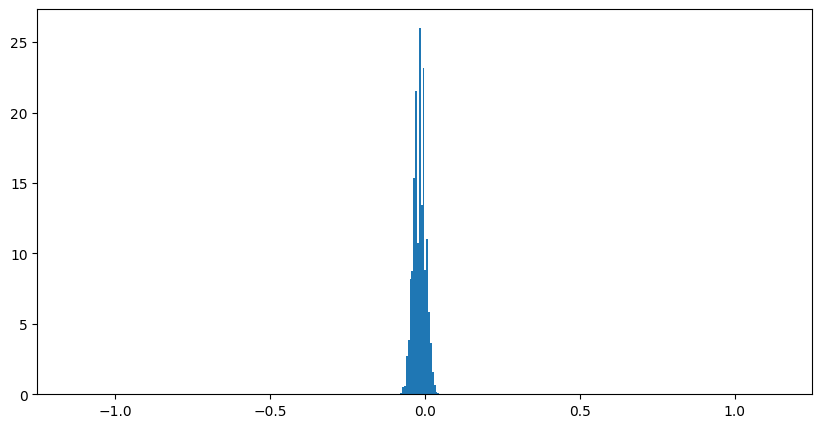

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(observations, bins=1000, density=True)
plt.xlim(-1.25, 1.25)
plt.show()

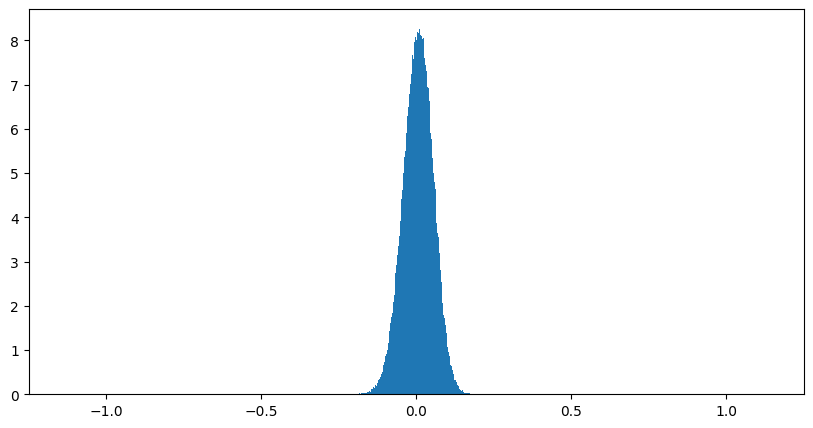

0.0011270551259616722

In [ ]:
regions = pickle.load(open('test/luad34.regions.entropies.pkl', 'rb'))
data = jnp.array(regions[regions.chrom != 19].loc[:, 'log2_corrected'].values)
plt.figure(figsize=(10, 5))
plt.hist(data, bins=1000, density=True)
plt.xlim(-1.25, 1.25)
plt.show()
observations.std() / n_states

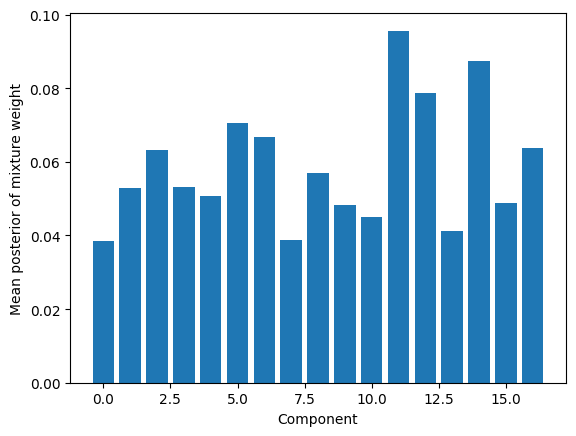

n: 0.9047, s: 0.0505, phi: 3.6982


In [ ]:
rng = np.random.RandomState(seed=45)
rng_key = jax.random.PRNGKey(76)

def batch_data(rng_key, data, batch_size, data_size):
    while True:
        _, rng_key = jax.random.split(rng_key)
        idx = jax.random.choice(
            key=rng_key, a=jnp.arange(data_size), shape=(batch_size,)
        )
        yield data[idx]

data_size =data.shape[0]
batch_size = data_size // 10
batches = batch_data(rng_key, data, batch_size, data_size)

def dirichlet_prior(states, target_state=jnp.array([2,2]), sigma=1.0):
    distances = jnp.linalg.norm(states - target_state, axis=1)
    return jnp.exp(-distances**2 / (2*sigma**2))

def logprior_fn(params):
    alpha, weights_param, n_param, s_param, phi_param, scale_param, nu_param = params
    alpha = jax.nn.softplus(alpha)
    weights = jax.nn.softmax(weights_param)
    n = jax.nn.sigmoid(n_param)
    s = jax.nn.sigmoid(s_param) / 2
    phi = 2 + 2 * jax.nn.sigmoid(phi_param)
    scale = jax.nn.softplus(scale_param)
    nu = jax.nn.softplus(nu_param)
    log_prior =  \
            InverseGamma(2, 1).log_prob(alpha) + \
            Dirichlet(dirichlet_prior(states, sigma=alpha)).log_prob(weights) + \
            Beta(20., 2.).log_prob(n) + \
            Beta(2., 20.).log_prob(s) + \
            Uniform(2, 4).log_prob(phi) + \
            sum(HalfNormal(0.1).log_prob(scale)) + \
            sum(Gamma(3, 1).log_prob(nu))
    return log_prior / data_size

def loglikelihood_fn(params, data):
    _, weights_param, n_param, s_param, phi_param, scale_param, nu_param = params
    weights = jax.nn.softmax(weights_param)
    n = jax.nn.sigmoid(n_param)
    s = jax.nn.sigmoid(s_param) / 2
    scale = jax.nn.softplus(scale_param)
    nu = jax.nn.softplus(nu_param)
    phi = 2 + 2 * jax.nn.sigmoid(phi_param)
    mu = jnp.log((2 * n + (1 - n) * ((1 - s) * states[:, 0] + s * states[:, 1])) / \
                (2 * n + (1 - n) * phi))

    likelihood_dist = MixtureSameFamily(Categorical(weights), StudentT(nu, mu, scale))
    log_likelihood = jnp.sum(likelihood_dist.log_prob(data))
    return log_likelihood / data_size

clonal = 6
states_set = \
    [[0, 0],
    [0, 1],
    [1, 0],
    [1, 1],
    [1, 2],
    [2, 1],
    [2, 2],
    [2, 3],
    [3, 2],
    [3, 3],
    [3, 4],
    [4, 3],
    [4, 4],
    [4, 5],
    [5, 4],
    [5, 5],
    [5, 6]]
states_df = pd.DataFrame(states_set, columns=['clonal', 'subclonal'])
states = jnp.array(states_df.values, dtype=jnp.float32)
n_states = len(states)

init_params = [
    1.1, 
    jnp.ones(n_states) / n_states, 
    2.197,
    -2.197,
    0.01,
    jnp.ones(n_states) / n_states, 
    jnp.ones(n_states) * 2.1
    ]
init_step_size = 1e-5
zeta = 2
sz = 2
num_warmup = 3000
num_samples = 2000
sample_size = num_samples
# schedule_fn = optax.linear_schedule(init_step_size, 0, num_warmup+num_samples)
schedule_fn = lambda _: init_step_size
grad_fn = grad_estimator(logprior_fn, loglikelihood_fn, len(data))
logdensity_fn = logdensity_estimator(logprior_fn, loglikelihood_fn, len(data))

sgld = blackjax.sgld(grad_fn)
state = sgld.init(init_params)
step_fn = jax.jit(sgld.step)

# sgld = blackjax.csgld(logdensity_fn, grad_fn, zeta=zeta)
# state = sgld.init(init_params)
# step_fn = jax.jit(sgld.step)

# sghmc = blackjax.sghmc(grad_fn, 10)
# state = sghmc.init(init_params)
# step_fn = jax.jit(sghmc.step)

alpha_posterior, weights_posterior, n_posterior, s_posterior, phi_posterior, scale_posterior, nu_posterior = ([] for i in range(7))
pb = progress_bar(range(num_warmup + num_samples))
for step in pb:
    _, rng_key = jax.random.split(rng_key)
    batch = next(batches)
    stepsize_SA = min(1e-2, (step + 100) ** (-0.8)) * sz
    state = step_fn(rng_key, state, batch, schedule_fn(step))
    # state = step_fn(rng_key, state, batch, schedule_fn(step), temperature=50)
    if step % 100 == 0:
        # pb.comment = f"| alpha: {jax.nn.softplus(state.position[0]):.4f}, " + \
        #         f"| n: {jax.nn.sigmoid(state.position[2]):.4f}, " + \
        #         f"s: {(jax.nn.sigmoid(state.position[3]) / 2):.4f}, " + \
        #             f"phi: {(2 + 3 * jax.nn.sigmoid(state.position[4])):.4f}, " + \
        #         f" {'Warmup' if step < num_warmup else 'Sampling'} |"
        pb.comment = f"| n: {jax.nn.sigmoid(state[2]):.4f}, " + \
                f"s: {(jax.nn.sigmoid(state[3]) / 2):.4f}, " + \
                    f"phi: {(2 + 2 * jax.nn.sigmoid(state[4])):.4f}, " + \
                f" {'Warmup' if step < num_warmup else 'Sampling'} |"

    if step > num_warmup:
        # alpha_posterior.append(state.position[0])
        # weights_posterior.append(state.position[1])
        # n_posterior.append(state.position[2])
        # s_posterior.append(state.position[3])
        # phi_posterior.append(state.position[4])
        # scale_posterior.append(state.position[5])
        # nu_posterior.append(state.position[6])
        alpha_posterior.append(state[0])
        weights_posterior.append(state[1])
        n_posterior.append(state[2])
        s_posterior.append(state[3])
        phi_posterior.append(state[4])
        scale_posterior.append(state[5])
        nu_posterior.append(state[6])

alpha_posterior = jax.nn.softplus(jnp.array(alpha_posterior))
weights_posterior = jax.nn.softmax(jnp.array(weights_posterior), axis=-1)
n_posterior = jax.nn.sigmoid(jnp.array(n_posterior))
s_posterior = jax.nn.sigmoid(jnp.array(s_posterior)) / 2
phi_posterior = 2 + 3 * jax.nn.sigmoid(jnp.array(phi_posterior))
scale_posterior = jax.nn.softplus(jnp.array(scale_posterior))
nu_posterior = jax.nn.softplus(jnp.array(nu_posterior))

alpha_mean = jnp.mean(alpha_posterior[-sample_size:], axis=0)
weights_mean = jnp.mean(weights_posterior[-sample_size:], axis=0)
n_mean = jnp.mean(n_posterior[-sample_size:], axis=0)
s_mean = jnp.mean(s_posterior[-sample_size:], axis=0)
phi_mean = jnp.mean(phi_posterior[-sample_size:], axis=0)
scale_mean = jnp.mean(scale_posterior[-sample_size:], axis=0)
nu_mean = jnp.mean(nu_posterior[-sample_size:], axis=0)

plt.ylabel('Mean posterior of mixture weight')
plt.xlabel('Component')
plt.bar(range(0, n_states), weights_mean)
plt.show()

print(f"n: {n_mean:.4f}, s: {s_mean:.4f}, phi: {phi_mean:.4f}")

In [ ]:
nu_mean

Array([2.56043410e+00, 3.27180648e+00, 1.88905816e-03, 4.83430004e+00,
       6.39753675e+00, 7.99713612e-01, 4.83764935e+00, 2.45910811e+00,
       8.18052101e+00, 6.19232714e-01, 1.28699875e+01, 4.32945371e-01,
       7.38408470e+00, 1.22136486e+00, 2.09255457e+00, 7.61340484e-02,
       1.31391678e+01], dtype=float32)

In [ ]:
# generate batches
def batch_data(rng_key, data, batch_size, data_size):
    """Return an iterator over batches of data."""
    while True:
        _, rng_key = jax.random.split(rng_key)
        idx = jax.random.choice(
            key=rng_key, a=jnp.arange(data_size), shape=(batch_size,)
        )
        yield data[idx]

In [ ]:
max_cluster_num = 30
dims = 1

rng_key = jax.random.PRNGKey(0)
mix_probs = jax.nn.softmax(jnp.ones([max_cluster_num]) / max_cluster_num)
df = jnp.ones([max_cluster_num, dims]) * 2.1
loc = jax.random.uniform(rng_key, minval=-0.4, maxval=0.4, shape=(max_cluster_num, dims))
precision = jax.nn.softplus(jnp.ones((max_cluster_num, dims)) * observations.std() / max_cluster_num)
alpha = jax.nn.softplus(jnp.ones([1]))

init_pos = {"mix_probs": mix_probs, "df": df, "loc": loc, "precision": precision, "alpha": alpha}

joint_dist = tfd.JointDistributionNamed(dict(
    alpha = tfd.InverseGamma(
        concentration=jnp.ones([1]),
        scale=jnp.ones([1]),
        name='alpha'),

    mix_probs = lambda alpha: tfd.Dirichlet(
        concentration=jnp.ones(max_cluster_num) * alpha / max_cluster_num,
        name='mix_probs'),
    
    df = tfd.Independent(
        tfd.InverseGamma(
            concentration=jnp.ones([max_cluster_num, dims]),
            scale=jnp.ones([max_cluster_num, dims])),
        reinterpreted_batch_ndims=1,
        name='df'),

    loc = tfd.Independent(
        tfd.Normal(
            loc=jnp.zeros([max_cluster_num, dims]),
            scale=jnp.ones([max_cluster_num, dims])),
        reinterpreted_batch_ndims=1,
        name='loc'),

    precision = tfd.Independent(
        tfd.InverseGamma(
            concentration=jnp.ones([max_cluster_num, dims]),
            scale=jnp.ones([max_cluster_num, dims])),
        reinterpreted_batch_ndims=1,
        name='precision')
))

data_size = observations.shape[0]
batch_size = 10000
batches = batch_data(rng_key, observations, batch_size, data_size)

def logprior_fn(position):
    alpha, df, loc, mix_probs, precision = jax.tree_util.tree_flatten(position)[0] 
    alpha, df, precision = jax.nn.softplus(alpha), jax.nn.softplus(df), jax.nn.softplus(precision)
    mix_probs = jax.nn.softmax(mix_probs, axis=-1)
    changed_position = {"alpha": alpha, "df":df, "loc": loc, "mix_probs": mix_probs,
                       "precision": precision}
    joint_logp = joint_dist.log_prob(changed_position)

    return jnp.sum(joint_logp, axis=-1) / num_samples

def loglikelihood_fn(position, batch_data):
    _, df, loc, mix_probs, precision = jax.tree_util.tree_flatten(position)[0]
    df, precision = jax.nn.softplus(df), jax.nn.softplus(precision)
    mix_probs = jax.nn.softmax(mix_probs, axis=-1)
    dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=mix_probs),
        components_distribution=tfd.StudentT(
            df=df.squeeze(),
            loc=loc.squeeze(),
            scale=precision.squeeze()))

    return dist.log_prob(batch_data) / batch_size



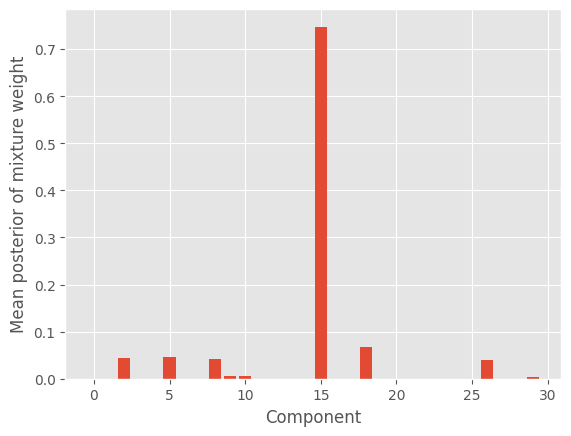

Value of inferred alpha = 1.903



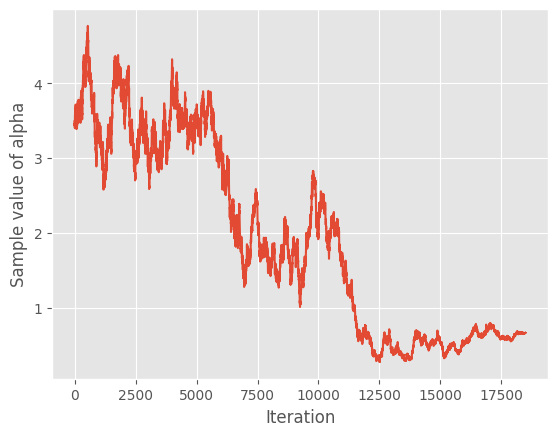

In [ ]:
def batch_data(rng_key, data, batch_size, data_size):
    while True:
        _, rng_key = jax.random.split(rng_key)
        idx = jax.random.choice(
            key=rng_key, a=jnp.arange(data_size), shape=(batch_size,)
        )
        yield data[idx]

data_size = observations.shape[0]
batch_size = 100
batches = batch_data(rng_key, observations, batch_size, data_size)

def inference_loop(rng_key, kernel, initial_state, num_samples, schedule_fn, step_size):

    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state, schedule_fn, step_size)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

init_step_size = 1e-3
num_warmup = 1500
num_samples = 20000
sample_size = data_size
schedule_fn = optax.linear_schedule(init_step_size, 1e-6, num_warmup+num_samples)
# schedule_fn = lambda _:  init_step_size
grad_fn = grad_estimator(logprior_fn, loglikelihood_fn, data_size)
logdensity_fn = logdensity_estimator(logprior_fn, loglikelihood_fn, data_size)
sgld = blackjax.csgld(logdensity_fn, grad_fn, zeta=10)
# sgld = blackjax.sgld(grad_fn)
state = sgld.init(init_pos)
step_fn = jax.jit(sgld.step)

post_samples = []
acc_info = []
sz = 1
pb = progress_bar(range(num_warmup + num_samples))
for step in pb:
    _, rng_key = jax.random.split(rng_key)
    stepsize_SA = min(1e-2, (step + 100) ** (-0.8)) * sz
    batch = next(batches)
    state = step_fn(rng_key, state, batch, schedule_fn(step), 1e-5)
    if step % 1000 == 0:
      pb.comment = f"| alpha: {state.position['alpha'][0]:.2f} "

    if step > num_warmup:
      post_samples.append(state)

mix_probs_posterior, alpha_posterior = [], []
loc_posterior, precision_posterior, df_posterior = [], [], []
for position in post_samples:
    position = position.position
    mix_probs_posterior.append(position["mix_probs"])
    df_posterior.append(position["df"])
    alpha_posterior.append(position["alpha"])
    loc_posterior.append(position["loc"])
    precision_posterior.append(position["precision"])


mix_probs_posterior = jax.nn.softmax(jnp.array(mix_probs_posterior)[num_warmup:], axis=-1)
alpha_posterior = jax.nn.softplus(jnp.array(alpha_posterior)[num_warmup:])
df_posterior = jax.nn.softplus(jnp.array(df_posterior)[num_warmup:])
precision_posterior = jax.nn.softplus(jnp.array(precision_posterior)[num_warmup:])
loc_posterior  = jnp.array(loc_posterior)[num_warmup:]

mean_mix_probs_ = jnp.mean(mix_probs_posterior[-sample_size:], axis=0)
mean_alpha_ = jnp.mean(alpha_posterior[-sample_size:], axis=0)
mean_df_ = jnp.mean(df_posterior[-sample_size:], axis=0)
mean_loc_ = jnp.mean(loc_posterior[-sample_size:], axis=0)
mean_precision_ = jnp.mean(precision_posterior[-sample_size:], axis=0)

plt.ylabel('Mean posterior of mixture weight')
plt.xlabel('Component')
plt.bar(range(0, max_cluster_num), mean_mix_probs_)
plt.show()

print('Value of inferred alpha = {0:.3f}\n'.format(mean_alpha_[0]))

plt.ylabel('Sample value of alpha')
plt.xlabel('Iteration')
plt.plot(alpha_posterior)
plt.show()

In [ ]:
mean_mix_probs_ > 0.01

Array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False], dtype=bool)

In [ ]:
def get_cluster_assignment(probs, loc, scale):
  component_dist = tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale)
  unnormalized_posterior = component_dist.log_prob(jnp.expand_dims(observations, axis=1)) + jnp.log(probs[None,...])
  posterior = unnormalized_posterior - jax.nn.logsumexp(unnormalized_posterior, axis=-1)[...,None]
  posterior = jnp.mean(posterior, axis=1)
  cluster = jnp.argmax(posterior, axis=1)
  return cluster
# Get cluster assignments
clusters = get_cluster_assignment(mean_probs, mean_loc, mean_scale)

In [ ]:
# cluster_assigment = get_cluster_assignment(mix_probs_posterior[-sample_size:], loc_posterior[-sample_size:], precision_posterior[-sample_size:])
cluster_assignment = get_cluster_assignment(
    mix_probs_posterior[-sample_size:], 
    loc_posterior[-sample_size:], 
    precision_posterior[-sample_size:]
)

idxs, count = jnp.unique(cluster_assigment, return_counts=True)

print('Number of inferred clusters = {}\n'.format(len(count)))

In [ ]:
def convert_int_elements_to_consecutive_numbers_in(array):
  unique_int_elements = np.unique(array)
  for consecutive_number, unique_int_element in enumerate(unique_int_elements):
    array[array == unique_int_element] = consecutive_number
  return array

In [ ]:
cluster_asgn = convert_int_elements_to_consecutive_numbers_in(np.array(cluster_assigment))

In [ ]:
cluster_asgn

array([ 3, 12, 12, ...,  3, 12,  4], dtype=int32)

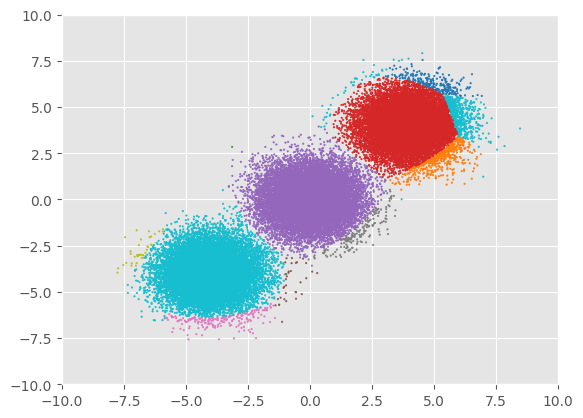

In [ ]:
cmap = plt.get_cmap('tab10')
plt.scatter(
    observations[:, 0], observations[:, 1],
    1,
    c=cmap(cluster_asgn))
plt.axis([-10, 10, -10, 10])
plt.show()

Value of inferred alpha = 1.124



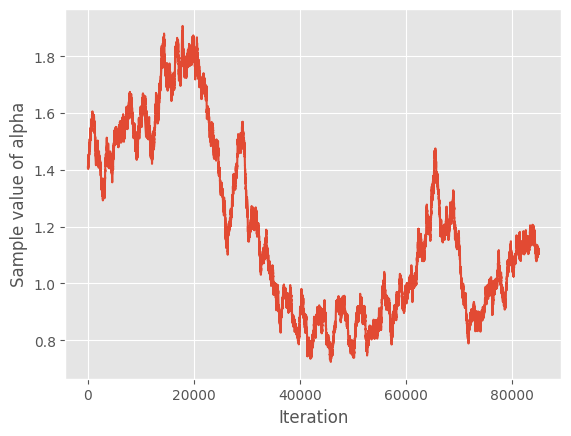

In [ ]:
print('Value of inferred alpha = {0:.3f}\n'.format(mean_alpha_[0]))

plt.ylabel('Sample value of alpha')
plt.xlabel('Iteration')
plt.plot(alpha_posterior)
plt.show()

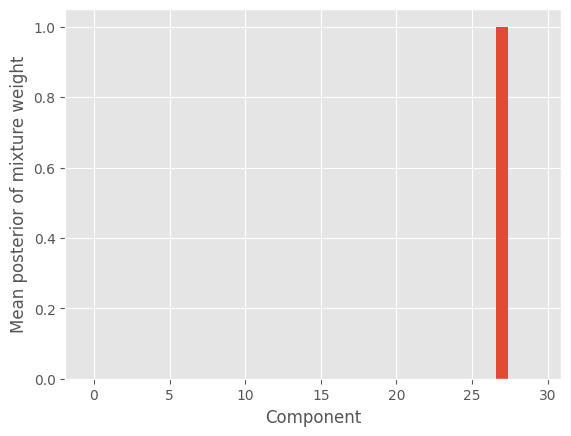

In [ ]:
plt.ylabel('Mean posterior of mixture weight')
plt.xlabel('Component')
plt.bar(range(0, max_cluster_num), mean_mix_probs_)
plt.show()

In [ ]:
jnp.log(mean_mix_probs_)

Array([-4.7441163, -5.402175 , -5.368508 , -5.1523786, -5.325961 ,
       -5.4786563, -3.969127 , -5.774149 , -6.0023923, -6.1356554,
       -1.5088079, -5.1626554, -1.1430589, -4.7558117, -4.3541813,
       -4.441424 , -5.066023 , -3.910173 , -5.2379236, -4.99495  ,
       -4.95974  , -5.543058 , -5.5359282, -1.330216 , -6.3860736,
       -5.662814 , -5.928524 , -3.6759045, -5.592727 , -4.9470673],      dtype=float32)

In [ ]:
mean_mix_probs_ > 0.1

Array([False, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False], dtype=bool)